$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
$$
# Part 1: Deep Reinforcement Learning
<a id=part1></a>

In the tutorial we have seen value-based reinforcement learning, in which we learn to approximate the action-value function $q(s,a)$.

In this exercise we'll explore a different approach, directly learning the agent's policy distribution, $\pi(a|s)$
by using *policy gradients*, in order to safely land on the moon!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prefer CPU, GPU won't help much in this assignment
device = 'cpu'
print('Using device:', device)

# Seed for deterministic tests
SEED = 42

Using device: cpu


Some technical notes before we begin:

- This part does not require a GPU. We won't need large models, and the computation bottleneck will be the generation of episodes to train on.
- In order to run this notebook on the server, you must prepend the `xvfb-run` command to create a virtual screen. For example,
    - to run the jupyter lab script with `srun` do
        ```
        srun -c2 --gres=gpu:1 xvfb-run -a -s "-screen 0 1440x900x24" ./jupyter-lab.sh
        ```
    - To run the submission script, do
        ```
        srun -c2 xvfb-run -a -s "-screen 0 1440x900x24" python main.py prepare-submission ...
        ```
    and so on.
- The OpenAI `gym` library is not officially supported on windows. However it should be possible to install and run the necessary environment for this exercise. However, we cannot provide you with technical support for this. If you have trouble installing locally, we suggest running on the course server.

## Policy gradients
<a id=part1_1></a>

Recall from the tutorial that we define the **policy** of an agent as the conditional distribution,
$$
\pi(a|s) = \Pr(a_t=a\vert s_t=s),
$$
which defines how likely the agent is to take action $a$ at state $s$.

Furthermore we define the action-value function,
$$
q_{\pi}(s,a) = \E{g_t(\tau)|s_t = s,a_t=a,\pi}
$$
where 
$$
g_t(\tau) = r_{t+1}+\gamma r_{t+2} + \dots = \sum_{k=0}^{\infty} \gamma^k r_{t+1+k},
$$
is the total discounted reward of a specific trajectory $\tau$ from time $t$, and the expectation in $q$ is over all possible
trajectories,
$
\tau=\left\{ (s_0,a_0,r_1,s_1), \dots (s_T,a_T,r_{T+1},s_{T+1}) \right\}.
$

In the tutorial we saw that we can learn a value function starting with some random function and
updating it iteratively by using the **Bellman optimality equation**.
Given that we have some action-value function, we can immediately create a policy based on that
by simply selecting an action which maximize the action-value at the current state, i.e.
$$
\pi(a|s) =
\begin{cases}
1, & a = \arg\max_{a'\in\cset{A}} q(s,a') \\
0, & \text{else}
\end{cases}.
$$
This is called $q$-learning. This approach aims to obtain a policy indirectly through the action-value function.
Yet, in most cases we don't actually care about knowing the value of particular states,
since all we need is a good policy for our agent. 

Here we'll take a different approach and learn a policy distribution $\pi(a|s)$ directly - by using **policy gradients**.

### Formalism

We define a parametric policy, $\pi_\vec{\theta}(a|s)$, and maximize total discounted reward (or minimize the negative reward):
$$
\mathcal{L}(\vec{\theta})=\E[\tau]{-g(\tau)|\pi_\vec{\theta}} = -\int g(\tau)p(\tau|\vec{\theta})d\tau,
$$
where $p(\tau|\vec{\theta})$ is the probability of a specific trajectory $\tau$ under the policy defined by $\vec{\theta}$.


Since we want to find the parameters $\vec{\theta}$ which minimize $\mathcal{L}(\vec{\theta})$, we'll compute the gradient w.r.t. $\vec{\theta}$:
$$
\grad\mathcal{L}(\vec{\theta}) = -\int g(\tau)\grad p(\tau|\vec{\theta})d\tau.
$$

Unfortunately, if we try to write $p(\tau|\vec{\theta})$ explicitly,
we find that computing it's gradient with respect to $\vec{\theta}$ is
quite intractable due to a huge product of terms depending on $\vec{\theta}$:
$$
p(\tau|\vec{\theta})=p\left(\left\{ (s_t,a_t,r_{t+1},s_{t+1})\right\}_{t\geq0}\given\vec{\theta}\right)
=p(s_0)\prod_{t\geq0} \pi_{\vec{\theta}}(a_t|s_t)p(s_{t+1}|s_t,a_t).
$$

However, by using the fact that $\grad_{x}\log(f(x))=\frac{\grad_{x}f(x)}{f(x)}$, we can convert the product into a sum:
$$
\begin{align}
\grad\mathcal{L}(\vec{\theta})
&= -\int g(\tau)\grad p(\tau|\vec{\theta})d\tau
= -\int g(\tau)\frac{\grad p(\tau|\vec{\theta})}{p(\tau|\vec{\theta})}p(\tau|\vec{\theta})d\tau \\
&= -\int g(\tau)\grad\log\left(p(\tau|\vec{\theta})\right)p(\tau|\vec{\theta})d\tau \\
&= -\int g(\tau)\grad\log\left( p(s_0)\prod_{t\geq0} \pi_{\vec{\theta}}(a_t|s_t)p(s_{t+1}|s_t,a_t) \right)
p(\tau|\vec{\theta})d\tau \\
&= -\int g(\tau)\grad\left( \log p(s_0) + \sum_{t\geq0} \log \pi_{\vec{\theta}}(a_t|s_t) + 
\sum_{t\geq0}\log p(s_{t+1}|s_t,a_t) \right) p(\tau|\vec{\theta})d\tau \\
&= -\int g(\tau)\sum_{t\geq0} \grad\log \pi_{\vec{\theta}}(a_t|s_t) p(\tau|\vec{\theta})d\tau \\
&= \E[\tau]{-g(\tau)\sum_{t\geq0} \grad\log \pi_{\vec{\theta}}(a_t|s_t)}.
\end{align}
$$

This is the "vanilla" version of the policy gradient. We can interpret is as a weighted log-likelihood function.
The log-policy is the log-likelihood term we wish to maximize and the total discounted reward acts as a weight: high-return positive
trajectories will cause the probability of actions taken during them to increase, and negative-return trajectories will cause the
probabilities of actions taken to decrease.

In the following figures we see three trajectories: high-return positive-reward (green), low-return positive-reward (yellow) and negative-return (red) and the action probabilities along the trajectories after the update. Credit: Sergey Levine.

|<strong></strong>||
|-----| ----|
|<img src="imgs/pg1.png" height="200">|<img src="imgs/pg2.png" height="200">|


The major drawback of the policy-gradient is it's high variance, which causes erratic optimization behavior and therefore slow convergence.
One reason for this is that the log-policy weight term, $g(\tau)$ can vary wildly between different trajectories, even if they're similar in
actions. Later on we'll implement the loss and explore some methods of variance reduction.

### Landing on the moon with policy gradients

In the spirit of the recent achievements of the Israeli space industry,
we'll apply our reinforcement learning skills to solve a simple game called **LunarLander**.

This game is available as an `environment` in OpenAI `gym`.

<video loop autoplay src="http://gym.openai.com/videos/2019-04-06--My9IiAbqha/LunarLander-v2/original.mp4" />

In this environment, you need to control the lander and get it to land safely on the moon.
To do so, you must apply bottom, right or left thrusters (each are either fully on or fully off)
and get it to land within the designated zone as quickly as possible and with minimal wasted fuel.

In [3]:
import gym

# Just for fun :) ... but also to re-define the default max number of steps
ENV_NAME = 'Beresheet-v2'
MAX_EPISODE_STEPS = 300
if ENV_NAME not in gym.envs.registry.env_specs:
    gym.register(
        id=ENV_NAME,
        entry_point='gym.envs.box2d:LunarLander',
        max_episode_steps=MAX_EPISODE_STEPS,
        reward_threshold=200,
    )

In [4]:
import gym

env = gym.make(ENV_NAME)

print(env)
print(f'observations space: {env.observation_space}')
print(f'action space: {env.action_space}')

ENV_N_ACTIONS = env.action_space.n
ENV_N_OBSERVATIONS = env.observation_space.shape[0]

/Users/Bar/miniconda3/envs/cs236781-hw/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<TimeLimit<LunarLander<Beresheet-v2>>>
observations space: Box(8,)
action space: Discrete(4)


The observations at each step is the Lander's position, velocity, angle, angular velocity and ground contact state.
The actions are no-op, fire left truster, bottom thruster and right thruster.

You are **highly encouraged** to read the [documentation](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py) in the source code of the `LunarLander` environment to understand the reward system,
and see how the actions and observations are created.

### Policy network and Agent

Let's start with our policy-model. This will be a simple neural net, which should take an observation and return a score for each possible action.

**TODO**:
1. Implement all methods in the `PolicyNet` class in the `hw4/rl_pg.py` module.
   Start small. A simple MLP with a few hidden layers is a good starting point. You can come back and change it later based on the the experiments. The we'll use the `build_for_env` method to instantiate a `PolicyNet` based on the configuration of a given environment.
2. If you need hyperparameters to configure your model (e.g. number of hidden layers, sizes, etc.), add them in `part1_pg_hyperparams()` in `hw4/answers.py`.

In [5]:
import hw4.rl_pg as hw4pg
import hw4.answers

hp = hw4.answers.part1_pg_hyperparams()

# You can add keyword-args to this function which will be populated from the hyperparameters dict.
p_net = hw4pg.PolicyNet.build_for_env(env, device, **hp)
p_net

PolicyNet(
  (extract_features): Sequential(
    (0): Linear(in_features=8, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
)

Now we need an **agent**. The purpose of our agent will be to act according to the current policy and generate experiences.
Our `PolicyAgent` will use a `PolicyNet` as the current policy function.


We'll also define some extra datatypes to help us represent the data generated by our agent.
You can find the `Experience`, `Episode` and `TrainBatch` datatypes in the `hw4/rl_pg.py` module.

**TODO**: Implement the `current_action_distribution()` method of the `PolicyAgent` class in the `hw4/rl_pg.py` module.

In [6]:
for i in range (10):
    agent = hw4pg.PolicyAgent(env, p_net, device)
    d = agent.current_action_distribution()
    test.assertSequenceEqual(d.shape, (env.action_space.n,))
    test.assertAlmostEqual(d.sum(), 1.0, delta=1e-5)
    
print(d)

tensor([0.2530, 0.2303, 0.2722, 0.2445])


**TODO**: Implement the `step()` method of the `PolicyAgent`.

In [7]:
agent = hw4pg.PolicyAgent(env, p_net, device)
exp = agent.step()

test.assertIsInstance(exp, hw4pg.Experience)
print(exp)

Experience(state=tensor([-0.0027,  1.4043, -0.2770, -0.2925,  0.0032,  0.0627,  0.0000,  0.0000]), action=1, reward=-2.277998156263577, is_done=False)


To test our agent, we'll write some code that allows it to play an environment. We'll use the `Monitor`
wrapper in `gym` to generate a video of the episode for visual debugging.

**TODO**: Complete the implementation of the `monitor_episode()` method of the `PolicyAgent`.

In [8]:
env, n_steps, reward = agent.monitor_episode(ENV_NAME, p_net, device=device)

To display the Monitor video in this notebook, we'll use a helper function from our `jupyter_utils` and a small wrapper that extracts the path of the last video file. 

In [9]:
import cs236781.jupyter_utils as jupyter_utils

def show_monitor_video(monitor_env, idx=0, **kw):
    # Extract video path
    video_path = monitor_env.videos[idx][0]
    video_path = os.path.relpath(video_path, start=os.path.curdir)
    
    # Use helper function to embed the video
    return jupyter_utils.show_video_in_notebook(video_path, **kw)

In [10]:
print(f'Episode ran for {n_steps} steps. Total reward: {reward:.2f}')

show_monitor_video(env)

Episode ran for 57 steps. Total reward: -86.73


### Training data

The next step is to create data to train on.
We need to train on batches of state-action pairs, so that our network can learn to predict the actions.

We'll split this task into three parts:
1. Generate a batch of `Episode`s, by using an `Agent` that's playing according to our current policy network.
   Each `Episode` object contains the `Experience` objects created by the agent.
2. Calculate the total discounted reward for each state we encountered and action we took. This is our action-value estimate.
3. Convert the `Episode`s into a batch of tensors to train on.
   Each batch will contain states, action taken per state, reward accrued, and the calculated estimated state-values.
   These will be stored in a `TrainBatch` object.


**TODO**: Complete the implementation of the `episode_batch_generator()` method in the `TrainBatchDataset` class within the `hw4.rl_data` module. This will address part 1 in the list above.

In [11]:
import hw4.rl_data as hw4data

def agent_fn():
    env = gym.make(ENV_NAME)
    hp = hw4.answers.part1_pg_hyperparams()
    p_net = hw4pg.PolicyNet.build_for_env(env, device, **hp)
    return hw4pg.PolicyAgent(env, p_net, device)
    
ds = hw4data.TrainBatchDataset(agent_fn, episode_batch_size=8, gamma=0.9)
batch_gen = ds.episode_batch_generator()
b = next(batch_gen)
print('First episode:', b[0])

test.assertEqual(len(b), 8)
for ep in b:
    test.assertIsInstance(ep, hw4data.Episode)
    
    # Check that it's a full episode
    is_done = [exp.is_done for exp in ep.experiences]
    test.assertFalse(any(is_done[0:-1]))
    test.assertTrue(is_done[-1])

/Users/Bar/miniconda3/envs/cs236781-hw/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


First episode: Episode(total_reward=-84.50, #experences=62)


**TODO**: Complete the implementation of the `calc_qvals()` method in the `Episode` class.
This will address part 2.
These q-values are an estimate of the actual action value function: $\hat{q}_{t} = \sum_{t'\geq t} \gamma^{t'}r_{t'+1}$.

In [12]:
np.random.seed(SEED)
test_rewards = np.random.randint(-10, 10, 100)
test_experiences = [hw4pg.Experience(None,None,r,False) for r in test_rewards] 
test_episode = hw4data.Episode(np.sum(test_rewards), test_experiences)

qvals = test_episode.calc_qvals(0.9)
qvals = list(qvals)

expected_qvals = np.load(os.path.join('tests', 'assets', 'part1_expected_qvals.npy'))
for i in range(len(test_rewards)):
    test.assertAlmostEqual(expected_qvals[i], qvals[i], delta=1e-3)

**TODO**: Complete the implementation of the `from_episodes()` method in the `TrainBatch` class.
This will address part 3.

Notes:
- The `TrainBatchDataset` class provides a generator function that will use the above function to lazily generate batches of training samples and labels on demand.
- This allows us to use a standard `PyTorch` dataloader to wrap our Dataset and provide us with parallel data loading for free!
  This means we can run multiple environments with multiple agents in separate background processes to generate data for training and thus prevent the data loading bottleneck which is caused by the fact that we must generate full Episodes to train on in order to calculate the q-values.
- We'll set the `DataLoader`'s `batch_size` to `None` because we have already implemented custom batching in our dataset.

In [13]:
from torch.utils.data import DataLoader

ds = hw4data.TrainBatchDataset(agent_fn, episode_batch_size=8, gamma=0.9)
dl = DataLoader(ds, batch_size=None, num_workers=2) # Run multiple agents/env in separate worker process


for i, train_batch in enumerate(dl):
    states, actions, qvals, reward_mean = train_batch
    print(f'#{i}: {train_batch}')
    test.assertEqual(states.shape[0], actions.shape[0])
    test.assertEqual(qvals.shape[0], actions.shape[0])
    test.assertEqual(states.shape[1], env.observation_space.shape[0])
    if i > 5:
        break

#0: TrainBatch(states: torch.Size([732, 8]), actions: torch.Size([732]), q_vals: torch.Size([732])), num_episodes: 8)
#1: TrainBatch(states: torch.Size([685, 8]), actions: torch.Size([685]), q_vals: torch.Size([685])), num_episodes: 8)
#2: TrainBatch(states: torch.Size([845, 8]), actions: torch.Size([845]), q_vals: torch.Size([845])), num_episodes: 8)
#3: TrainBatch(states: torch.Size([737, 8]), actions: torch.Size([737]), q_vals: torch.Size([737])), num_episodes: 8)
#4: TrainBatch(states: torch.Size([750, 8]), actions: torch.Size([750]), q_vals: torch.Size([750])), num_episodes: 8)
#5: TrainBatch(states: torch.Size([818, 8]), actions: torch.Size([818]), q_vals: torch.Size([818])), num_episodes: 8)
#6: TrainBatch(states: torch.Size([762, 8]), actions: torch.Size([762]), q_vals: torch.Size([762])), num_episodes: 8)


### Loss functions

As usual, we need a loss function to optimize over.
We'll calculate three types of losses:
1. The causal vanilla policy gradient loss.
1. The policy gradient loss, with a baseline to reduce variance.
2. An entropy-based loss whos purpose is to diversify the agent's action selection,
   and prevent it from being "too sure" about its actions.
   This loss will be used together with one of the above losses.

#### Causal vanilla policy-gradient

We have derived the policy-gradient as
$$
\grad\mathcal{L}(\vec{\theta}) = \E[\tau]{-g(\tau)\sum_{t\geq0} \grad\log \pi_{\vec{\theta}}(a_t|s_t)}.
$$

By writing the discounted reward explicitly and enforcing causality, i.e. the action taken at time $t$ can't affect
the reward at time $t'<t$, we can get a slightly lower-variance version of the policy gradient:

$$
\grad\mathcal{L}_{\text{PG}}(\vec{\theta}) = 
\E[\tau]{-\sum_{t\geq0} \left(\sum_{t'\geq t} \gamma^{t'}r_{t'+1} \right)\grad\log \pi_{\vec{\theta}}(a_t|s_t)}.
$$

In practice, the expectation over trajectories is calculated using a Monte-Carlo approach, i.e. simply sampling $N$
trajectories and average the term inside the expectation. Therefore, we will use the following estimated version of the policy gradient:

$$
\begin{align}
\hat\grad\mathcal{L}_{\text{PG}}(\vec{\theta})
&=-\frac{1}{N}\sum_{i=1}^{N}\sum_{t\geq0} \left(\sum_{t'\geq t} \gamma^{t'}r_{i,t'+1} \right)\grad\log \pi_{\vec{\theta}}(a_{i,t}|s_{i,t}) \\
&=-\frac{1}{N}\sum_{i=1}^{N}\sum_{t\geq0} \hat{q}_{i,t} \grad\log \pi_{\vec{\theta}}(a_{i,t}|s_{i,t}).
\end{align}
$$

Note the use of the notation $\hat{q}_{i,t}$ to represent the estimated action-value at time $t$ in the sampled trajectory $i$.
Here $\hat{q}_{i,t}$ is acting as the weight-term for the policy gradient.

**TODO**: Complete the implementation of the `VanillaPolicyGradientLoss` class in the `hw4/rl_pg.py` module.

In [14]:
# Ensure deterministic run
env = gym.make(ENV_NAME)
env.seed(SEED)
torch.manual_seed(SEED)

def agent_fn():
    # Use a simple "network" here, so that this test doesn't depend on your specific PolicyNet implementation
    p_net_test = nn.Linear(8, 4)
    agent = hw4pg.PolicyAgent(env, p_net_test)
    return agent

dataloader = hw4data.TrainBatchDataset(agent_fn, gamma=0.9, episode_batch_size=4)

test_batch = next(iter(dataloader))
test_action_scores = torch.randn(len(test_batch), env.action_space.n)

loss_fn_p = hw4pg.VanillaPolicyGradientLoss()
loss_p, _ = loss_fn_p(test_batch, test_action_scores)

print('loss =', loss_p)
test.assertAlmostEqual(loss_p.item(), -35.535522, delta=1e-3)

loss = tensor(-35.5355)


#### Policy-gradient with baseline

Another way to reduce the variance of our gradient is to use relative weighting of the log-policy instead of absolute reward values.
$$
\hat\grad\mathcal{L}_{\text{BPG}}(\vec{\theta})
=-\frac{1}{N}\sum_{i=1}^{N}\sum_{t\geq0} \left(\hat{q}_{i,t}-b\right) \grad\log \pi_{\vec{\theta}}(a_{i,t}|s_{i,t}).
$$
In other words, we don't measure a trajectory's worth by it's total reward, but by how much better that total reward is relative to some
expected ("baseline") reward value, denoted above by $b$.
Note that subtracting a baseline has no effect on the expected value of the policy gradient. It's easy to prove this directly by definition.

Here we'll implement a very simple baseline (not optimal in terms of variance reduction): the average of the estimated state-values $\hat{q}_{i,t}$.

**TODO**: Complete the implementation of the `BaselinePolicyGradientLoss` class in the `hw4/rl_pg.py` module.

In [15]:
# Using the same batch and action_scores from above cell
loss_fn_p = hw4pg.BaselinePolicyGradientLoss()
loss_p, _ = loss_fn_p(test_batch, test_action_scores)

print('loss =', loss_p)
test.assertAlmostEqual(loss_p.item(), -2.4665009, delta=1e-3)

loss = tensor(-2.4665)


#### Entropy loss

The entropy of a probability distribution (in our case the policy), is
$$
H(\pi) = -\sum_{a} \pi(a|s)\log\pi(a|s).
$$
The entropy is always positive and obtains it's maximum for a uniform distribution.
We'll use the entropy of the policy as a bonus, i.e. we'll try to maximize it.
The idea is the prevent the policy distribution from becoming too narrow and thus promote the agent's exploration.

First, we'll calculate the maximal possible entropy value of the action distribution for a set number of possible actions.
This will be used as a normalization term.

**TODO**: Complete the implementation of the `calc_max_entropy()` method in the `ActionEntropyLoss` class.

In [16]:
loss_fn_e = hw4pg.ActionEntropyLoss(env.action_space.n)
print('max_entropy = ', loss_fn_e.max_entropy)

test.assertAlmostEqual(loss_fn_e.max_entropy, 1.38629436, delta=1e-3)

max_entropy =  tensor(1.3863)


**TODO**: Complete the implementation of the `forward()` method in the `ActionEntropyLoss` class.

In [17]:
loss_e, _ = loss_fn_e(test_batch, test_action_scores)
print('loss = ', loss_e)

test.assertAlmostEqual(loss_e.item(), -0.7927002, delta=1e-3)

loss =  tensor(-0.7927)


### Training

We'll implement our training procedure as follows:

1. Initialize the current policy to be a random policy.
1. Sample $N$ trajectories from the environment using the current policy.
2. Calculate the estimated $q$-values, $\hat{q}_{i,t} = \sum_{t'\geq t} \gamma^{t'}r_{i,t'+1}$ for each trajectory $i$.
3. Calculate policy gradient estimate $\hat\grad\mathcal{L}(\vec{\theta})$ as defined above.
4. Perform SGD update $\vec{\theta}\leftarrow\vec{\theta}-\eta\hat\grad\mathcal{L}(\vec{\theta})$.
5. Repeat from step 2.

This is known as the **REINFORCE** algorithm.

Fortunately, we've already implemented everything we need for steps 1-4 so we need only a bit more code to put it all together.

The following block implements a wrapper, `train_pg` to create all the objects we need in order to train our policy gradient model.


In [18]:
import hw4.answers
from functools import partial

ENV_NAME = "Beresheet-v2"

def agent_fn_train(agent_type, p_net, seed, envs_dict):
    winfo = torch.utils.data.get_worker_info()
    wid = winfo.id if winfo else 0
    seed = seed + wid if seed else wid

    env = gym.make(ENV_NAME)
    envs_dict[wid] = env
    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    return agent_type(env, p_net)

def train_rl(agent_type, net_type, loss_fns, hp, seed=None, checkpoints_file=None, **train_kw):
    print(f'hyperparams: {hp}')
    
    envs = {}
    p_net = net_type(ENV_N_OBSERVATIONS, ENV_N_ACTIONS, **hp)
    p_net.share_memory()
    agent_fn = partial(agent_fn_train, agent_type, p_net, seed, envs)
    
    dataset = hw4data.TrainBatchDataset(agent_fn, hp['batch_size'], hp['gamma'])
    dataloader = DataLoader(dataset, batch_size=None, num_workers=2)
    optimizer = optim.Adam(p_net.parameters(), lr=hp['learn_rate'], eps=hp['eps'])
    
    trainer = hw4pg.PolicyTrainer(p_net, optimizer, loss_fns, dataloader, checkpoints_file)
    try:
        trainer.train(**train_kw)
    except KeyboardInterrupt as e:
        print('Training interrupted by user.')
    finally:
        for env in envs.values():
            env.close()

    # Include final model state
    training_data = trainer.training_data
    training_data['model_state'] = p_net.state_dict()
    return training_data
    
def train_pg(baseline=False, entropy=False, **train_kwargs):
    hp = hw4.answers.part1_pg_hyperparams()
    
    loss_fns = []
    if baseline:
        loss_fns.append(hw4pg.BaselinePolicyGradientLoss())
    else:
        loss_fns.append(hw4pg.VanillaPolicyGradientLoss())
    if entropy:
        loss_fns.append(hw4pg.ActionEntropyLoss(ENV_N_ACTIONS, hp['beta']))

    return train_rl(hw4pg.PolicyAgent, hw4pg.PolicyNet, loss_fns, hp, **train_kwargs)

The `PolicyTrainer` class implements the training loop, collects the losses and rewards and provides some useful checkpointing functionality.
The training loop will generate batches of episodes and train on them until either:
- The average total reward from the last `running_mean_len` episodes is greater than the `target_reward`, OR
- The number of generated episodes reached `max_episodes`.

Most of this class is already implemented for you. 

**TODO**:
1. Complete the training loop by implementing the `train_batch()` method of the `PolicyTrainer`.
2. Tweak the hyperparameters in the `part1_pg_hyperparams()` function within the `hw4/answers.py` module as needed. You get some sane defaults.

Let's check whether our model is actually training.
We'll try to reach a very low (bad) target reward, just as a sanity check to see that training works.
Your model should be able to reach this target reward within a few batches.

You can increase the target reward and use this block to manually tweak your model and hyperparameters a few times.

In [19]:
target_reward = -150 # VERY LOW target
train_data = train_pg(target_reward=target_reward, seed=SEED, max_episodes=6000, running_mean_len=10)

test.assertGreater(train_data['mean_reward'][-1], target_reward)

hyperparams: {'batch_size': 32, 'gamma': 0.995, 'beta': 0.7, 'learn_rate': 0.001, 'eps': 1e-08, 'hidden_layers': [512, 256]}
=== Training...
#2: step=00008284, loss_p=-166.44, m_reward(10)=-129.5 (best=-183.3):   2%|▏         | 96/6000 [00:07<07:52, 12.49it/s]

=== 🚀 SOLVED - Target reward reached! 🚀


### Experimenting with different losses

We'll now run a few experiments to see the effect of diferent loss functions on the training dynamics. Namely, we'll try:
1. Vanilla PG (`vpg`): No baseline, no entropy
2. Baseline PG (`bpg`): Baseline, no entropy loss
3. Entropy PG (`epg`): No baseline, with entropy loss
3. Combined PG (`cpg`): Baseline, with entropy loss

In [20]:
from collections import namedtuple
from pprint import pprint
import itertools as it


ExpConfig = namedtuple('ExpConfig', ('name','baseline','entropy'))

def exp_configs():
    exp_names = ('vpg', 'epg', 'bpg', 'cpg')
    z = zip(exp_names, it.product((False, True), (False, True)))
    return (ExpConfig(n, b, e) for (n, (b, e)) in z)

pprint(list(exp_configs()))

[ExpConfig(name='vpg', baseline=False, entropy=False),
 ExpConfig(name='epg', baseline=False, entropy=True),
 ExpConfig(name='bpg', baseline=True, entropy=False),
 ExpConfig(name='cpg', baseline=True, entropy=True)]


We'll save the training data from each experiment for plotting.

In [21]:
import pickle

def dump_training_data(data, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, mode='wb') as file:
        pickle.dump(data, file)
        
def load_training_data(filename):
    with open(filename, mode='rb') as file:
        return pickle.load(file)

Let's run the experiments! We'll run each configuration for a fixed number of episodes so that we can compare them.

The results will be saved in a file. To re-run the experiments, delete the `training_data_filename`.

Note: You can decrease the number of episodes for each experiment, or only run one experiment until your models start working.

In [22]:
import math

exp_max_episodes = 6000

results = {}
training_data_filename = os.path.join('results', f'part1_exp.dat')

# Set to True to force re-run (careful, will delete old experiment results)
force_run = False

# Skip running if results file exists.
if os.path.isfile(training_data_filename) and not force_run:
    print(f'=== results file {training_data_filename} exists, skipping experiments.')
    results = load_training_data(training_data_filename)
    
else:
    for n, b, e in exp_configs():
        print(f'=== Experiment {n}')
        results[n] = train_pg(baseline=b, entropy=e, max_episodes=exp_max_episodes, post_batch_fn=None)
        
    dump_training_data(results, training_data_filename)

=== results file results/part1_exp.dat exists, skipping experiments.


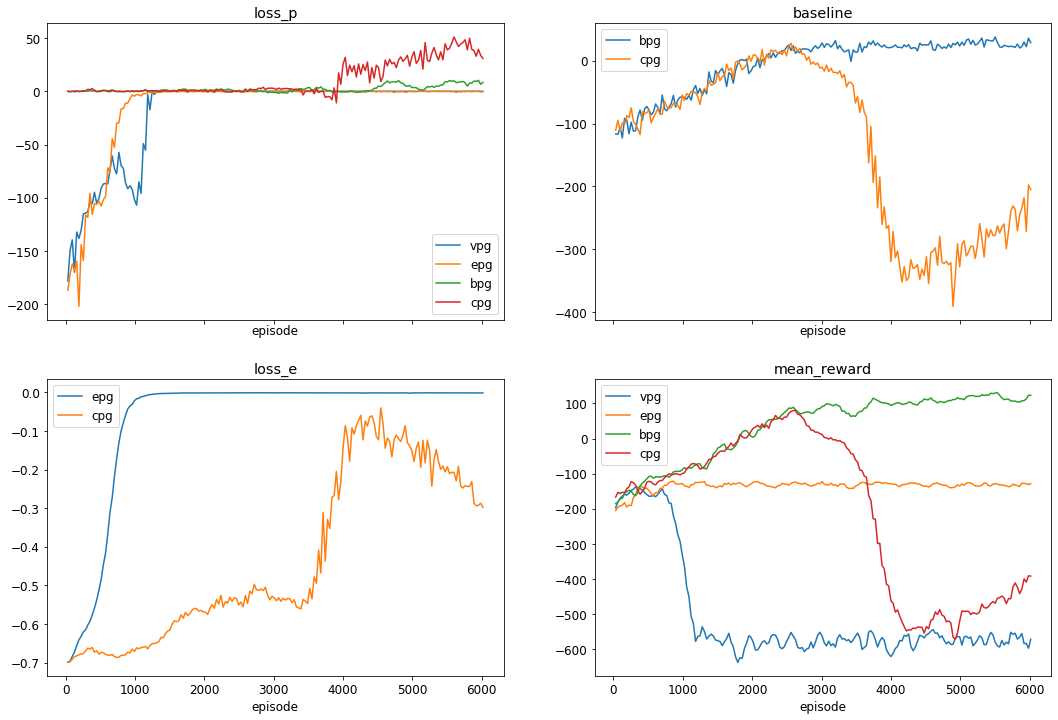

In [23]:
def plot_experiment_results(results, fig=None):
    if fig is None:
        fig, _ = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(18,12))
    for i, plot_type in enumerate(('loss_p', 'baseline', 'loss_e', 'mean_reward')):
        ax = fig.axes[i]
        for exp_name, exp_res in results.items():
            if plot_type not in exp_res:
                continue
            ax.plot(exp_res['episode_num'], exp_res[plot_type], label=exp_name)
        ax.set_title(plot_type)
        ax.set_xlabel('episode')
        ax.legend()
    return fig
    
experiments_results_fig = plot_experiment_results(results)

You should see positive training dynamics in the graphs (reward going up).
If you don't, use them to further update your model or hyperparams.

To pass the test, you'll need to get a best total mean reward of at least 10 in the fixed number of epochs using the combined loss.
It's possible to get much higher (over 100).

In [24]:
best_cpg_mean_reward = max(results['cpg']['mean_reward'])
print(f'Best CPG mean reward: {best_cpg_mean_reward:.2f}')

test.assertGreater(best_cpg_mean_reward, 10)

Best CPG mean reward: 79.76


Now let's take a look at a gameplay video of our `cpg` model after the short training!

In [25]:
hp = hw4.answers.part1_pg_hyperparams()
p_net_cpg = hw4pg.PolicyNet.build_for_env(env, **hp)
p_net_cpg.load_state_dict(results['cpg']['model_state'])

env, n_steps, reward = hw4pg.PolicyAgent.monitor_episode(ENV_NAME, p_net_cpg)
print(f'{n_steps} steps, total reward: {reward:.2f}')
show_monitor_video(env)

/Users/Bar/miniconda3/envs/cs236781-hw/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


50 steps, total reward: -333.49


## Advantage Actor-Critic (AAC)
<a id=part1_2></a>

We have seen that the policy-gradient loss can be interpreted as a log-likelihood of the policy term
(selecting a specific action at a specific state), weighted by the future rewards of that choice of action.

However, naïvely weighting by rewards has significant drawbacks in terms of the variance of the resulting gradient.
We addressed this by adding a simple baseline term which represented our "expected reward" so that we increase probability of actions
leading to trajectories which exceed this expectation and vice-versa.

In this part we'll explore a more powerful baseline, which is the idea behind the A2C method.

### The advantage function

Recall the definition of the state-value function $v_{\pi}(s)$ and action-value function $q_{\pi}(s,a)$:

$$
\begin{align}
v_{\pi}(s) &= \E{g(\tau)|s_0 = s,\pi} \\
q_{\pi}(s,a) &= \E{g(\tau)|s_0 = s,a_0=a,\pi}.
\end{align}
$$

Both these functions represent the value of the state $s$. However, $v_\pi$ averages over the first action according to the policy,
while $q_\pi$ fixes the first action and then continues according to the policy.

Their difference is known as the **advantage function**:
$$
a_\pi(s,a) = q_\pi(s,a)-v_\pi(s).
$$

If $a_\pi(s,a)>0$ it means that it's better (in expectation) to take action $a$ in state $s$ compared to the average action.
In other words, $a_\pi(s,a)$ represents the *advantage* of using action $a$ in state $s$ compared to the others.

So far we have used an estimate for $q_\pi$ as our weighting term for the log-policy, with a fixed baseline per batch.

$$
\hat\grad\mathcal{L}_{\text{BPG}}(\vec{\theta})
=-\frac{1}{N}\sum_{i=1}^{N}\sum_{t\geq0} \left(\hat{q}_{i,t}-b\right) \grad\log \pi_{\vec{\theta}}(a_{i,t}|s_{i,t}).
$$


Now, we will use the state value as a baseline, so that an estimate of the advantage function is our weighting term:

$$
\hat\grad\mathcal{L}_{\text{AAC}}(\vec{\theta})
=-\frac{1}{N}\sum_{i=1}^{N}\sum_{t\geq0} \left(\hat{q}_{i,t}-v_\pi(s_t)\right) \grad\log \pi_{\vec{\theta}}(a_{i,t}|s_{i,t}).
$$

Intuitively, using the advantage function makes sense because it means we're weighting our policy's actions according to
how advantageous they are compared to other possible actions.

But how will we know $v_\pi(s)$? We'll learn it of course, using another neural network.
This is known as actor-critic learning. We simultaneously learn the policy (actor) and the value of states (critic).
We'll treat it as a regression task: given a state $s_t$, our state-value network will output $\hat{v}_\pi(s_t)$,
an estimate of the actual unknown state-value.
Our regression targets will be the discounted rewards, $\hat{q}_{i,t}$ (see question 2),
and we can use a simple MSE as the loss function,
$$
\mathcal{L}_{\text{SV}} = \frac{1}{N}\sum_{i=1}^{N}\sum_{t\geq0}\left(\hat{v}_\pi(s_t) - \hat{q}_{i,t}\right)^2.
$$


### Implementation

We'll build heavily on our implementation of the regular policy-gradient method, and just add a new model class and a new loss class, with a small modification to the agent.

Let's start with the model. It will accept a state, and return action scores (as before), but also the value of that state.
You can experiment with a dual-head network that has a shared base, or implement two separate parts within the network.

**TODO**:
1. Implement the model as the `AACPolicyNet` class in the `hw4/rl_ac.py` module.
1. Set the hyperparameters in the `part1_aac_hyperparams()` function of the `hw4.answers` module.

In [26]:
import hw4.rl_ac as hw4ac

hp = hw4.answers.part1_aac_hyperparams()
pv_net = hw4ac.AACPolicyNet.build_for_env(env, device, **hp)
pv_net

AACPolicyNet(
  (extract_features_action): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
  (extract_features_value): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

**TODO**: Complete the implementation of the agent class, `AACPolicyAgent`, in the `hw4/rl_ac.py` module.

In [27]:
agent = hw4ac.AACPolicyAgent(env, pv_net, device)
exp = agent.step()

test.assertIsInstance(exp, hw4pg.Experience)
print(exp)

Experience(state=tensor([-0.0033,  1.4013, -0.3379, -0.4277,  0.0039,  0.0765,  0.0000,  0.0000]), action=0, reward=-1.3658541499065961, is_done=False)


**TODO**: Implement the AAC loss function as the class `AACPolicyGradientLoss` in the `hw4/rl_ac.py` module.

In [28]:
loss_fn_aac = hw4ac.AACPolicyGradientLoss(delta=1.)
test_state_values = torch.ones(test_action_scores.shape[0], 1)
loss_t, _ = loss_fn_aac(test_batch, (test_action_scores, test_state_values))

print('loss_t =', loss_t)
test.assertAlmostEqual(loss_t.item(), 975.230895, delta=1e-3)

loss_t = tensor(975.2310)


### Experimentation

Let's run the same experiment as before, but with the AAC method and compare the results.

In [29]:
def train_aac(baseline=False, entropy=False, **train_kwargs):
    hp = hw4.answers.part1_aac_hyperparams()
    loss_fns = [hw4ac.AACPolicyGradientLoss(hp['delta']), hw4pg.ActionEntropyLoss(ENV_N_ACTIONS, hp['beta'])]
    return train_rl(hw4ac.AACPolicyAgent, hw4ac.AACPolicyNet, loss_fns, hp, **train_kwargs)

In [30]:
training_data_filename = os.path.join('results', f'part1_exp_aac.dat')

# Set to True to force re-run (careful, will delete old experiment results)
force_run = False

if os.path.isfile(training_data_filename) and not force_run:
    print(f'=== results file {training_data_filename} exists, skipping experiments.')
    results_aac = load_training_data(training_data_filename)
    
else:
    print(f'=== Running AAC experiment')
    training_data = train_aac(max_episodes=6000)
    results_aac = dict(aac=training_data)
    dump_training_data(results_aac, training_data_filename)

=== results file results/part1_exp_aac.dat exists, skipping experiments.


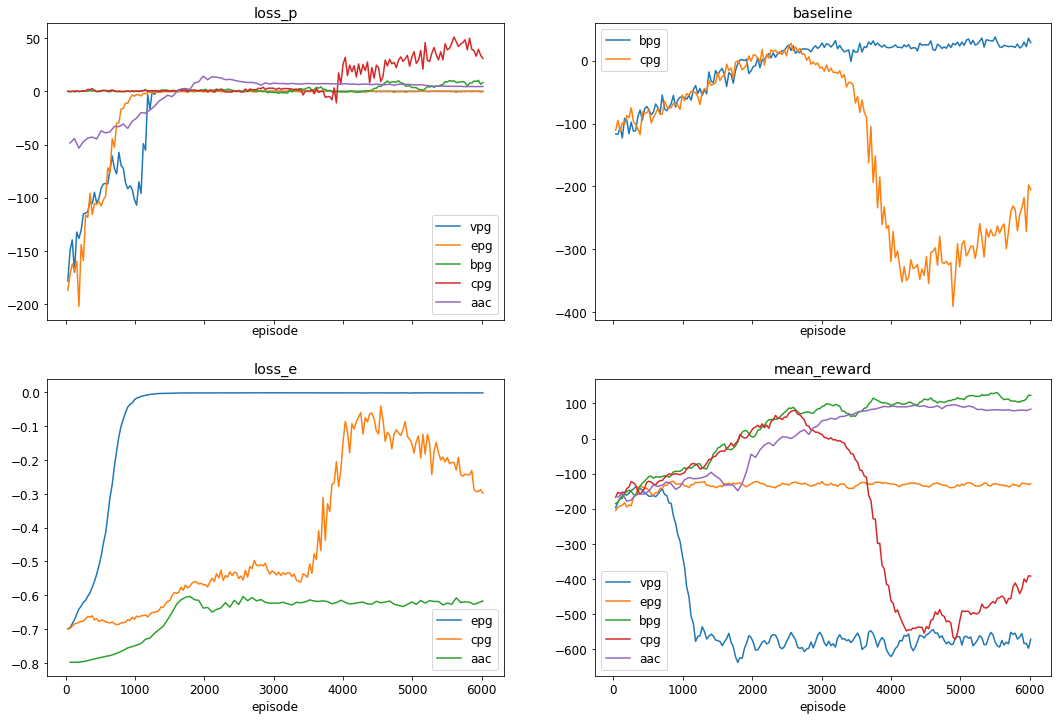

In [31]:
experiments_results_fig = plot_experiment_results(results)
plot_experiment_results(results_aac, fig=experiments_results_fig);

You should get better results with the AAC method, so this time the bar is higher (again, you should aim for a mean reward of 100+).
Compare the graphs with combined PG method and see if they make sense.

In [32]:
best_aac_mean_reward = max(results_aac['aac']['mean_reward'])
print(f'Best AAC mean reward: {best_aac_mean_reward:.2f}')

test.assertGreater(best_aac_mean_reward, 50)

Best AAC mean reward: 96.35


### Final model training and visualization

Now, using your best model and hyperparams, let's train model for much longer and see the performance.
Just for fun, we'll also visualize an episode every now and then so that we can see how well the agent is playing.

In [33]:
import IPython.display

CHECKPOINTS_FILE = f'checkpoints/{ENV_NAME}-ac.dat'
CHECKPOINTS_FILE_FINAL = f'checkpoints/{ENV_NAME}-ac_final.dat'
# TARGET_REWARD = 125
TARGET_REWARD = 10
MAX_EPISODES = 15_000

def post_batch_fn(batch_idx, p_net, batch, print_every=20, final=False):
    if not final and batch_idx % print_every != 0:
        return
    env, n_steps, reward = hw4ac.AACPolicyAgent.monitor_episode(ENV_NAME, p_net)
    html = show_monitor_video(env, width="500")
    IPython.display.clear_output(wait=True)
    print(f'Monitor@#{batch_idx}: n_steps={n_steps}, total_reward={reward:.3f}, final={final}')
    IPython.display.display_html(html)
    
    
if os.path.isfile(CHECKPOINTS_FILE_FINAL):
    print(f'=== {CHECKPOINTS_FILE_FINAL} exists, skipping training...')
    checkpoint_data = torch.load(CHECKPOINTS_FILE_FINAL)
    hp = hw4.answers.part1_aac_hyperparams()
    pv_net = hw4ac.AACPolicyNet.build_for_env(env, **hp)
    pv_net.load_state_dict(checkpoint_data['params'])
    print(f'=== Running best model...')
    env, n_steps, reward = hw4ac.AACPolicyAgent.monitor_episode(ENV_NAME, pv_net)
    print(f'=== Best model ran for {n_steps} steps. Total reward: {reward:.2f}')
    # IPython.display.display_html(show_monitor_video(env))
    best_mean_reward = checkpoint_data["best_mean_reward"]
else:
    print(f'=== Starting training...')
    train_data = train_aac(TARGET_REWARD, max_episodes=MAX_EPISODES,
                           seed=None, checkpoints_file=CHECKPOINTS_FILE, post_batch_fn=post_batch_fn)
    print(f'=== Done, ', end='')
    best_mean_reward = train_data["best_mean_reward"][-1]
    print(f'num_episodes={train_data["episode_num"][-1]}, best_mean_reward={best_mean_reward:.1f}')
          
test.assertGreaterEqual(best_mean_reward, TARGET_REWARD)

=== checkpoints/Beresheet-v2-ac_final.dat exists, skipping training...
=== Running best model...


/Users/Bar/miniconda3/envs/cs236781-hw/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


=== Best model ran for 300 steps. Total reward: 80.22


## Questions
<a id=part1_3></a>

**TODO**: Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [34]:
from cs236781.answers import display_answer
import hw4.answers

### Question 1

Explain qualitatively why subtracting a baseline in the policy-gradient helps reduce it's variance.
Specifically, give an example where it helps.

In [35]:
display_answer(hw4.answers.part1_q1)


**Your answer:**

The advantage is the amount of how much the current action is better than what we would usually do in that state.
In policy gradient methods, we update the policy in the direction of received reward.
However, in tcomplicated task, the policy may recive different rewards. Therefor, the policy
may need to collect many experiances and average them over the different rewards.
With that said, the advantage has lower variance since the baseline compensates for the variance introduced by
being in different states.


Imagine that we have two different trajectories in our batch. The first has a positive total reward and the second has a negative one.
In this case, it's easy for the PG to update the policy such that the first trajectory's actions get higher probability. 
However, if we add a constant value to our reward function, for example such that the second one receives zero reward, this time the gradient will be completely different since it will not reduce the probabilities for the sends trajectory at all.

Adding a baseline fixes this dependence on absolute values of the rewards, since we'll compare all rewards to some constant number.
In the example above, subtracting a baseline will cause the gradient to be the same in both cases.

### Question 2

In AAC, when using the estimated q-values as regression targets for our state-values, why do we get a valid approximation?
Hint: how is $v_\pi(s)$ expressed in terms of $q_\pi(s,a)$?

In [36]:
display_answer(hw4.answers.part1_q2)


**Your answer:**
The estimated q-values is calculated in order to estimate the value of the next move. 
If we agree that the estimate q-value is actually giving a good estimation, therefore,
it can be used to estimate a state value. 



### Question 3

1. Analyze and explain the graphs you got in first experiment run.
2. Compare the experiment graphs you got with the AAC method to the regular PG method (`cpg`).

In [37]:
display_answer(hw4.answers.part1_q3)


**Your answer:**
1. In the first experiament we tried to compare between 4 different losses. 
The loss_p graph represent the loss of each function. while the loss_e represent
only the entropy loss (only for cpg and epg). They both influence over the mean_reward graph which
represent the rewards in each iteration for each loss function.
It is abvious that the bpg got the best resault while the cpg falls after around 2500 episodes.
The vpg is failing and doesn't improve after the 1000 episodes and ath epg remaines relatively constant.


2. Around 3000 episodes the aac is overcoming the cpg in terms of mean rewards. The fall of the
cpg is aligned to the base line graph which falls around that amount of episodes. Moreover,
the loss_p graph shows that the cpg loss is increasing from (around) 3000 episodes while in that 
time the aac loss decrease toward the zero.

